In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import tensorflow.keras as keras

We import the fashion mnist data set from tensor flow

In [2]:
from tensorflow.keras.datasets import fashion_mnist
import numpy
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [3]:
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()


We preprocess the images in order to feed them to our model and train it

In [4]:
train_images[0].shape

(28, 28)

In [5]:
train_images=train_images.astype('float32')/255
test_images=test_images.astype('float32')/255

In [6]:
train_images[0].min()

0.0

In [7]:
train_images=train_images.reshape(train_images.shape[0],28,28,1)

In [8]:
test_images=test_images.reshape(test_images.shape[0],28,28,1)

We reshape the images into 28 x 28 and greyscale

In [9]:
train_images[0].shape

(28, 28, 1)

We create a function to later apply data augmentation in order to generate more data for our model,we do so by rotating the images,flipping and zooming in the pre exisiting data

In [10]:
data_augmentation=tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomFlip(),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1,0.1)
])

We create our model by choosing 32 neurons, 3 x 3 kernel size
we augment the input data and then begin by convolving the input image data with the kernel
The dot products of the kernel create a feature map,we run the map through the relu activation function
We then apply batch normalization to the data so that we can normalize the data befpre going to the next layer
Maxpooling applies a new filter to the feature map which selects the maximum value of a pixel from the given section
and Spatialdropout drops some of the data to avoid overfitting

In [11]:
def create_model():
    inputs=keras.Input(shape=(28,28,1))
    x=data_augmentation(inputs)
    
    x=keras.layers.Conv2D(32,3,activation="relu",padding="same")(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Conv2D(32,3,activation="relu",padding="same")(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.MaxPool2D(2)(x)
    x=keras.layers.SpatialDropout2D(0.2)(x)

    x=keras.layers.Conv2D(64,3,activation="relu",padding="same")(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Conv2D(64,3,activation="relu",padding="same")(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.MaxPool2D(2)(x)
    x=keras.layers.SpatialDropout2D(0.2)(x)

    residual=x
    x=keras.layers.Conv2D(64,3,activation="relu",padding="same")(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Conv2D(64,3,activation="relu",padding="same")(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.add([x,residual])

    x=keras.layers.GlobalAveragePooling2D()(x)
    x=keras.layers.Dense(256,activation="relu")(x)
    outputs=keras.layers.Dense(10,activation="softmax")(x)
    
    model=keras.Model(inputs,outputs)
    return model

We begin training our model and import EarlyStopping to stop the number of epochs in case the accuracy does not change with increase 
in epochs,this is to avoid unnecessary computing

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

patience is set to 10 such that it will stop if accuracy does not change after 10 epochs

In [13]:
callbacks=[EarlyStopping(patience=10,restore_best_weights=True)]

In [14]:
model=create_model()

In [15]:
from tensorflow.keras.optimizers import Adam

In [16]:
model.compile(optimizer=Adam(learning_rate=0.001),loss="sparse_categorical_crossentropy",metrics=['accuracy'])

history=model.fit(train_images,train_labels,callbacks=callbacks,epochs=50,batch_size=16,validation_data=(test_images,test_labels))

In [ ]:
We save our model using the joblib module.

In [18]:
import joblib
joblib.dump(model,'model.pkl')

['model.pkl']

We check our models accuracy

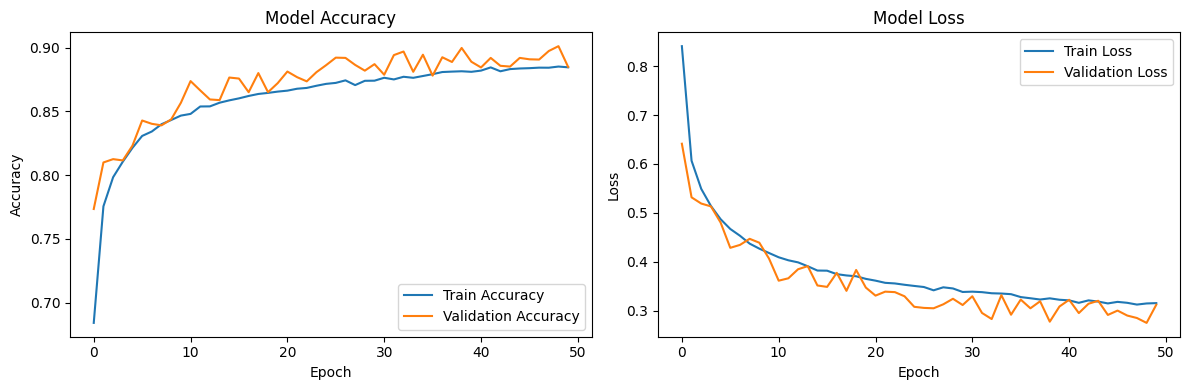

In [19]:
import seaborn as sns
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
y_pred=model.predict(test_images).argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


We see how accurately our model will be able to identify certain pieces of fashion

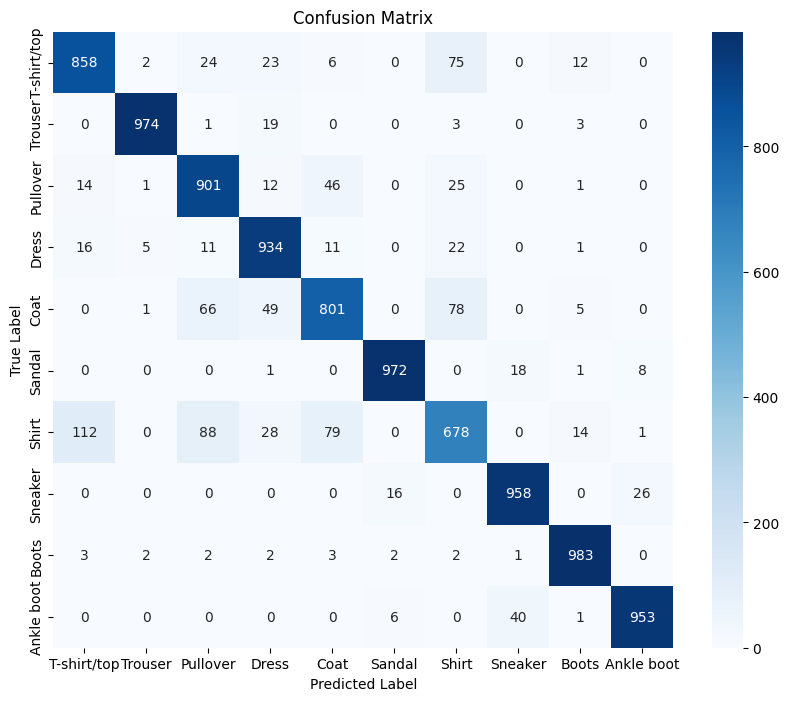

In [21]:


def plot_confusion_matrix(y_true,y_pred,classes):
    cm=tf.math.confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=classes,yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Boots','Ankle boot']
plot_confusion_matrix(test_labels,y_pred,class_names)

In [22]:
from sklearn.metrics import classification_report

In [23]:
import pprint

In [24]:
pprint.pprint(classification_report(test_labels,y_pred))

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.86      0.86      0.86      1000\n'
 '           1       0.99      0.97      0.98      1000\n'
 '           2       0.82      0.90      0.86      1000\n'
 '           3       0.87      0.93      0.90      1000\n'
 '           4       0.85      0.80      0.82      1000\n'
 '           5       0.98      0.97      0.97      1000\n'
 '           6       0.77      0.68      0.72      1000\n'
 '           7       0.94      0.96      0.95      1000\n'
 '           8       0.96      0.98      0.97      1000\n'
 '           9       0.96      0.95      0.96      1000\n'
 '\n'
 '    accuracy                           0.90     10000\n'
 '   macro avg       0.90      0.90      0.90     10000\n'
 'weighted avg       0.90      0.90      0.90     10000\n')


In [25]:
import numpy as np

In [26]:
import tensorflow as tf

In [27]:
from PIL import Image

In order to make an actual prediction based on an image,we need to first preprocess it in order for our model to
be able to analyze it and make a prediction.
The proprocess_image function does so and returns an image array for our model

In [28]:
def preprocess_image(image_path):
    img=Image.open(image_path)
    if img.mode!='L':
        img=img.convert('L')
    img=img.resize((28,28))
    img_array=np.array(img).astype('float32')/255.0
    img_array=img_array.reshape(1,28,28,1)
    return img_array

The image array is given to our model for it to make a prediction

In [29]:
def predict_class(model,image_array):
    prediction=model.predict(image_array)
    class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Boots','Ankle boot']
    #class_names=['one','two','three','four','five','six','seven','eight','nine','ten']
    class_index=np.argmax(prediction)
    predicted_class=class_names[class_index]
    confidence=prediction[0][class_index]
    return predicted_class,confidence
    

We test our model by seeing how well it guesses the articles of fashion

In [30]:
image_path="pant.jpg"
processed_image=preprocess_image(image_path)
predicted_class,confidence=predict_class(model,processed_image)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class: Trouser
Confidence: 0.58


In [32]:
image_path="bootz.jpg"
processed_image=preprocess_image(image_path)
predicted_class,confidence=predict_class(model,processed_image)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: Boots
Confidence: 1.00


In [35]:
image_path="C:\\Users\\91984\\Desktop\\tshirt.jpg"
processed_image=preprocess_image(image_path)
predicted_class,confidence=predict_class(model,processed_image)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class: Boots
Confidence: 0.48
